# Calculating Night Ligt Intensity

In [ ]:
import os
import ee
import geemap 
import pandas as pd

#ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [ ]:
# Define your region of interest (Peru/Brazil Amazon)
amazon_roi = ee.Geometry.BBox(-75, -15, -50, 5)  # Adjust coordinates as needed

# Load the Harmonized Nighttime Lights (DMSP-OLS) for 2000
dmsp = (ee.ImageCollection("projects/sat-io/open-datasets/Harmonized_NTL/dmsp")
          .filterDate('2000-01-01', '2000-12-31')
          .mean())

# Create a map
Map = geemap.Map(center=[-5, -65], zoom=5)

# Add the Nighttime Lights layer
vis_params = {
    'min': 0,
    'max': 63,
    'palette': ['000000', 'ffffff']
}

Map.addLayer(dmsp, vis_params, 'DMSP-OLS NTL 2000')
Map


Map(center=[-5, -65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [12]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=dmsp,
    description='nightlight2000_1km',
    folder='GEE_exports',
    fileNamePrefix='nightlight2000_1km',
    region=world_bbox,
    scale=1000,
    maxPixels=1e13
)

task.start()

In [22]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

import mapclassify

from rapidfuzz import process, fuzz

from shapely.geometry import Point

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
from glob import glob
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling

import tempfile

In [7]:
# Set base project path
base_path = Path("C:/Users/juami/Dropbox/RAships/2-Folklore-Nathan-Project/EA-Maps-Nathan-project/Measures_work")

# Set file paths
poscol_path = base_path / "data" / "raw" / "ethnologue" / "ancestral_characteristics_database_language_level" / "Ethnologue_16_shapefile" / "langa_no_overlap_biggest_clean.shp"

data_path = base_path / "data" / "interim"
maps_path = base_path / "maps" / "raw"
nl_path = base_path / "maps" / "raw" / "NL"

export_path = base_path / "maps" / "interim" / "ethnologue_parts"

In [8]:
# Read the shapefiles and CSV files
ethnologue = gpd.read_file(poscol_path)

# Keep only relevant columns
ethnologue = ethnologue[["ID", "geometry"]]

print(f"Number of features: {len(ethnologue)}") 

Number of features: 7087


In [17]:
# List all the raster files 
raster_files = glob(str(nl_path / "*.tif"))

print("Found raster files:", raster_files)

# Read in all the rasters
src_files_to_mosaic = [rasterio.open(fp) for fp in raster_files]

from rasterio.merge import merge

# Set a coarser resolution
mosaic, out_trans = merge(
    src_files_to_mosaic,
    res=(0.01, 0.01),  # Approx ~1km resolution (in degrees)
    resampling=Resampling.average  # Can also try Resampling.nearest
)

Found raster files: ['C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\NL\\nightlight2000_1km-0000000000-0000000000.tif', 'C:\\Users\\juami\\Dropbox\\RAships\\2-Folklore-Nathan-Project\\EA-Maps-Nathan-project\\Measures_work\\maps\\raw\\NL\\nightlight2000_1km-0000000000-0000023296.tif']


In [18]:
# Check CRS of each input raster
for i, src in enumerate(src_files_to_mosaic):
    print(f"Raster {i} CRS:", src.crs)

ethnologue = ethnologue.to_crs(src_files_to_mosaic[0].crs)

Raster 0 CRS: EPSG:4326
Raster 1 CRS: EPSG:4326


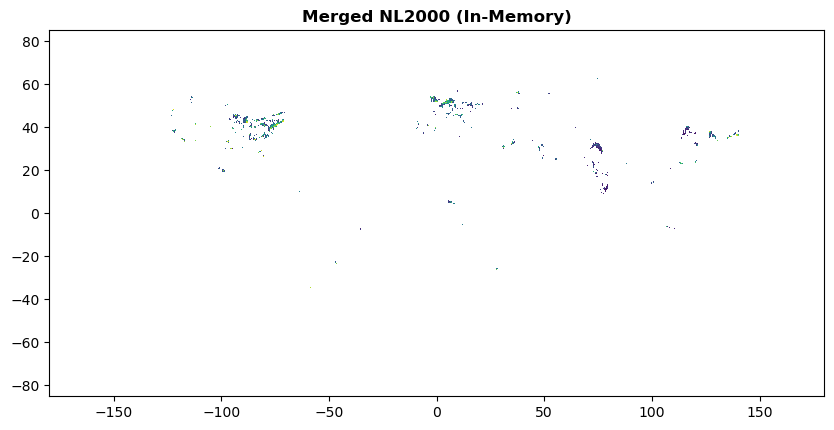

In [19]:
# Show the first band of the mosaic directly
fig, ax = plt.subplots(figsize=(10, 10))
show(mosaic, transform=out_trans, ax=ax, title="Merged NL2000 (In-Memory)")
plt.show()

In [23]:
# Write mosaic to a temporary file on disk
with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmpfile:
    tmp_path = tmpfile.name

with rasterio.open(
    tmp_path,
    'w',
    driver='GTiff',
    height=mosaic.shape[1],  # Note: shape order is (bands, rows, cols)
    width=mosaic.shape[2],
    count=1,
    dtype=mosaic.dtype,
    crs='EPSG:4326',
    transform=out_trans
) as dst:
    dst.write(mosaic[0], 1)  # If mosaic has shape (1, rows, cols)

# Compute zonal stats from that file
stats = zonal_stats(
    ethnologue,
    tmp_path,
    stats=['mean'],
    geojson_out=True
)

# Add to GeoDataFrame
ethnologue['nl_mean'] = [f['properties']['mean'] for f in stats]

print(ethnologue[['ID', 'nl_mean']].head())

c:\Users\juami\anaconda3\envs\geo\lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


        ID    nl_mean
0  RUS-RUS  13.271797
1  ENG-USA  17.610254
2  POR-BRA  14.371451
3  ENG-AUS  13.554563
4  CMN-CHN   8.897684


In [24]:
df_ethnologue = ethnologue[['ID', 'nl_mean']]

df_ethnologue.head()

,ID,nl_mean
0,RUS-RUS,13.271797
1,ENG-USA,17.610254
2,POR-BRA,14.371451
3,ENG-AUS,13.554563
4,CMN-CHN,8.897684


In [25]:
len(df_ethnologue)

7087

In [26]:
# Export to CSV
df_ethnologue.to_csv(nl_path / "ethnologue_nl.csv", index=False)

print(f"Exported df_ethnologue.csv")

Exported df_ethnologue.csv
